# Generating tags using topic modeling for Vietnamese recipes!

## Data collection

Let's scrap the data now from a website!

In [166]:
from bs4 import BeautifulSoup
import requests

url = 'https://www.recipetineats.com/category/vietnamese-recipes/'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

Now that we have parsed through the website HTML, let's get all of the recipe links using find_all

In [167]:
recipe_links = soup.find_all('a', class_= 'entry-image-link')
# Get the href attribute to store the link
links = []
for recipe in recipe_links:
    links.append(recipe.get('href'))
print(links)

['https://www.recipetineats.com/crispy-pork-belly-banh-mi/', 'https://www.recipetineats.com/vietnamese-pickled-carrots-daikon/', 'https://www.recipetineats.com/vietnamese-lettuce-wraps-with-peanut-sauce/', 'https://www.recipetineats.com/vietnamese-caramel-ginger-chicken/', 'https://www.recipetineats.com/vietnamese-pork-noodle-bowls/', 'https://www.recipetineats.com/vietnamese-lemongrass-pork-steaks/', 'https://www.recipetineats.com/chicken-banh-mi-vietnamese-sandwich/', 'https://www.recipetineats.com/red-vietnamese-fried-rice/', 'https://www.recipetineats.com/vietnamese-shaking-beef/', 'https://www.recipetineats.com/vietnamese-baked-chicken/', 'https://www.recipetineats.com/vietnamese-chicken-salad/', 'https://www.recipetineats.com/vietnamese-chicken-pho-soup-pho-ga/', 'https://www.recipetineats.com/vietnamese-rice-paper-rolls-spring-rolls/', 'https://www.recipetineats.com/vietnamese-pho-recipe/', 'https://www.recipetineats.com/vietnamese-top-10-best-street-food-ho-chi-minh-city/', 'ht

After getting all of the links for all of the recipe, let's iterate through each recipe title to see if it works

In [168]:
from urllib.parse import urljoin

for link in links:
    recipe_page = requests.get(link)

    recipe_soup = BeautifulSoup(recipe_page.content, 'html.parser')

    # Extract the recipe's title
    recipe_title = recipe_soup.find('h1').get_text()
    print(f'Recipe Title: {recipe_title}')

Recipe Title: Crispy pork belly banh mi
Recipe Title: Vietnamese pickled carrots and daikon (radish)
Recipe Title: Vietnamese Lettuce Wraps with Peanut Sauce
Recipe Title: Vietnamese Caramel Ginger Chicken
Recipe Title: Vietnamese lemongrass pork noodle bowls (bun thit nuong)
Recipe Title: Vietnamese lemongrass pork steaks
Recipe Title: Chicken Banh Mi (Vietnamese sandwich)
Recipe Title: Red Vietnamese Fried Rice
Recipe Title: Vietnamese Shaking Beef
Recipe Title: Vietnamese Baked Chicken
Recipe Title: Vietnamese Chicken Salad
Recipe Title: Vietnamese Chicken Pho soup (Pho Ga)
Recipe Title: Vietnamese Rice Paper Rolls
Recipe Title: Vietnamese Pho recipe
Recipe Title: {Pilot Travel Video!!} Top 10 BEST Street Food in Vietnam – Ho Chi Minh City
Recipe Title: Vietnamese Noodles with Lemongrass Chicken
Recipe Title: Vietnamese Caramelised Pork Bowls
Recipe Title: Banh Mi ! (Vietnamese sandwich)
Recipe Title: Pork Meatballs for Banh Mi
Recipe Title: Caramelised Vietnamese Shredded Beef


Now that we're able to iterate through each of the link, we can start create a pipeline to extracts the necessary information (ingredients, instructions, and title)

In [169]:
def extract_info(div_class, ul_class, extra_char_to_strip, soup):
    divs = soup.find_all('div', class_= div_class)
    list_of_info = []
    for div in divs:
        ul = div.find_next('ul', class_=ul_class)
        for li in ul.find_all('li'):
            list_of_info.append(li.get_text().strip(extra_char_to_strip))
    return list_of_info

In [170]:
from urllib.parse import urljoin
import pandas as pd
# Create a dataframe storing all of the vietnamese recipes
recipes_df = pd.DataFrame(columns=['Title', 'Ingredients', 'Instructions', 'Tags'])
for link in links:
    recipe_page = requests.get(link)

    recipe_soup = BeautifulSoup(recipe_page.content, 'html.parser')

    # Extract the recipe's title and add to df
    recipe_title = recipe_soup.find('h1').get_text()

    new_row = pd.DataFrame({'Title': [recipe_title], 'Ingredients': [extract_info('wprm-recipe-ingredient-group', 'wprm-recipe-ingredients','▢ ', recipe_soup)], 'Instructions': [extract_info('wprm-recipe-instruction-group', 'wprm-recipe-instructions','▢ ', recipe_soup)]})
    recipes_df = pd.concat([recipes_df, new_row], ignore_index=True)

Remove the links that couldn't be scraped

In [171]:
recipes_df = recipes_df.drop([8,9,14])

In [172]:
recipes_df

,Title,Ingredients,Instructions,Tags
0,Crispy pork belly banh mi,"[1kg / 2 lb pork belly with skin on , NOT SCOR...",[Dry skin overnight: Place pork belly on a pla...,NaN
1,Vietnamese pickled carrots and daikon (radish),"[2 medium carrots , peeled cut into 3mm / 1/10...","[Pickle – In a large bowl, dissolve the salt a...",NaN
2,Vietnamese Lettuce Wraps with Peanut Sauce,[300g / 10 oz peeled whole cooked prawns/shrim...,"[Pickle first – Put the boiling water, salt an...",NaN
3,Vietnamese Caramel Ginger Chicken,"[1 kg / 2 lb skinless chicken thigh fillets , ...","[Toss chicken with fish sauce and chilli, then...",NaN
4,Vietnamese lemongrass pork noodle bowls (bun t...,[1 batch lemongrass marinated pork (it’s marin...,"[Pickle – In a large bowl, dissolve the salt a...",NaN
5,Vietnamese lemongrass pork steaks,"[500g/1 lb pork shoulder , skinless and bonele...","[Cut pork – Cut into 8 equal, thinnish slices ...",NaN
6,Chicken Banh Mi (Vietnamese sandwich),"[2 medium carrots , peeled cut into 2-3mm / 1/...","[Pickle – In a large bowl, dissolve the salt a...",NaN
7,Red Vietnamese Fried Rice,"[30g / 2 tbsp unsalted butter, 3 garlic cloves...",[Melt most of the butter in a large non-stick ...,NaN
10,Vietnamese Chicken Salad,"[350g/12oz cooked chicken , cut into thin bato...",[Dressing: Shake Dressing ingredients in a jar...,NaN
11,Vietnamese Chicken Pho soup (Pho Ga),"[1 tbsp oil , vegetable or canola (or other pl...",[Char onion & ginger - Heat oil in a 6 litre /...,NaN


Our df is almost done! Now, we just need to append tags for each of the food's description. To do so, we'll use NLP's library called spacy and download its pre-trained model. We'll use this model to find tags and filter out unecessary words.

In [173]:
import spacy

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# The food description
text = ("I find it funny that pho is the dish that’s become the superstar of Vietnamese food when bun thit nuong is tastier to me! "
        "I adore the contrast of fresh vegetables and herbs with delicious grilled meats, that it’s light and healthy yet anything but dull. "
        "It’s a big bowl of delicious, and I shared the chicken version many years ago (bun ga nuong). "
        "And as soon as I cracked the pork version, I shared in immediately (just last Wednesday!). "
        "And I’m back today with the noodle bowls recipe that is made using the lemongrass pork – just like you get on the streets of Vietnam!")


# Process the text
doc = nlp(text)

# Extract tags with filtering
filtered_tags = [token.text for token in doc 
                 if token.pos_ not in ["PRON", "VERB","AUX", "ADP","SYM","PREP"]
                 and not token.is_stop
                 and not token.is_punct]

# Print extracted tags
print(filtered_tags)

['funny', 'pho', 'dish', 'superstar', 'Vietnamese', 'food', 'bun', 'nuong', 'tastier', 'contrast', 'fresh', 'vegetables', 'herbs', 'delicious', 'meats', 'light', 'healthy', 'dull', 'big', 'bowl', 'delicious', 'chicken', 'version', 'years', 'ago', 'bun', 'ga', 'nuong', 'soon', 'pork', 'version', 'immediately', 'Wednesday', 'today', 'noodle', 'bowls', 'recipe', 'lemongrass', 'pork', 'like', 'streets', 'Vietnam']


Based on this filtering, we can see that the tags found from this description are good. Let's add a column into the df called food description and apply this pipeline to append to the tags column.

In [174]:
# Add an empty column calle Description
recipes_df["Description"] = None

In [175]:
from bs4 import BeautifulSoup
import requests 
recipes_df = pd.DataFrame(columns=['Title', 'Ingredients', 'Instructions', 'Tags', 'Description'])
for link in links:
    recipe_page = requests.get(link)

    recipe_soup = BeautifulSoup(recipe_page.content, 'html.parser')

    recipe_title = recipe_soup.find('h1').get_text()
    print(recipe_title)
    h2_heading = recipe_soup.find('h2', class_ = ['has-text-align-center wp-block-heading', 'wp-block-heading has-text-align-center', 'text-align: center;'])
    paragraphs_block = []
    if h2_heading:
        for sibling in h2_heading.find_next_siblings():
            if sibling.name == "h2" or sibling.name == "h3":
                break
            if sibling.name == "p":
                paragraphs_block.append(sibling.get_text().strip())
    new_row = pd.DataFrame({'Title': [recipe_title], 'Ingredients': [' '.join(extract_info('wprm-recipe-ingredient-group', 'wprm-recipe-ingredients','▢ ', recipe_soup))], 'Instructions': [' '.join(extract_info('wprm-recipe-instruction-group', 'wprm-recipe-instructions','▢ ', recipe_soup))], 'Description': [' '.join(paragraphs_block)]})
    recipes_df = pd.concat([recipes_df, new_row], ignore_index=True)

Crispy pork belly banh mi
Vietnamese pickled carrots and daikon (radish)
Vietnamese Lettuce Wraps with Peanut Sauce
Vietnamese Caramel Ginger Chicken
Vietnamese lemongrass pork noodle bowls (bun thit nuong)
Vietnamese lemongrass pork steaks
Chicken Banh Mi (Vietnamese sandwich)
Red Vietnamese Fried Rice
Vietnamese Shaking Beef
Vietnamese Baked Chicken
Vietnamese Chicken Salad
Vietnamese Chicken Pho soup (Pho Ga)
Vietnamese Rice Paper Rolls
Vietnamese Pho recipe
{Pilot Travel Video!!} Top 10 BEST Street Food in Vietnam – Ho Chi Minh City
Vietnamese Noodles with Lemongrass Chicken
Vietnamese Caramelised Pork Bowls
Banh Mi ! (Vietnamese sandwich)
Pork Meatballs for Banh Mi
Caramelised Vietnamese Shredded Beef


In [176]:
# Remove the row containing the Top 10 Street food in Vietnam.
recipes_df1 = recipes_df.copy()
recipes_df1 = recipes_df1.drop([8,9,14])


In [177]:
recipes_df1

,Title,Ingredients,Instructions,Tags,Description
0,Crispy pork belly banh mi,"1kg / 2 lb pork belly with skin on , NOT SCORE...",Dry skin overnight: Place pork belly on a plat...,NaN,I recently had the best banh mi of my life at ...
1,Vietnamese pickled carrots and daikon (radish),"2 medium carrots , peeled cut into 3mm / 1/10""...","Pickle – In a large bowl, dissolve the salt an...",NaN,If you’ve been to Vietnam or Vietnamese restau...
2,Vietnamese Lettuce Wraps with Peanut Sauce,300g / 10 oz peeled whole cooked prawns/shrimp...,"Pickle first – Put the boiling water, salt and...",NaN,These lettuce wraps are not strictly Vietnames...
3,Vietnamese Caramel Ginger Chicken,"1 kg / 2 lb skinless chicken thigh fillets , c...","Toss chicken with fish sauce and chilli, then ...",NaN,"When you see today’s recipe, you’re going to d..."
4,Vietnamese lemongrass pork noodle bowls (bun t...,1 batch lemongrass marinated pork (it’s marina...,"Pickle – In a large bowl, dissolve the salt an...",NaN,I find it funny that pho is the dish that’s be...
5,Vietnamese lemongrass pork steaks,"500g/1 lb pork shoulder , skinless and boneles...","Cut pork – Cut into 8 equal, thinnish slices o...",NaN,I’ve been wanting to recreate the chargrilled ...
6,Chicken Banh Mi (Vietnamese sandwich),"2 medium carrots , peeled cut into 2-3mm / 1/1...","Pickle – In a large bowl, dissolve the salt an...",NaN,Banh Mi is a meat filled French baguette sandw...
7,Red Vietnamese Fried Rice,"30g / 2 tbsp unsalted butter 3 garlic cloves ,...",Melt most of the butter in a large non-stick s...,NaN,Fried rice always makes for a great quick meal...
10,Vietnamese Chicken Salad,"350g/12oz cooked chicken , cut into thin baton...",Dressing: Shake Dressing ingredients in a jar....,NaN,While this exact salad is not strictly authent...
11,Vietnamese Chicken Pho soup (Pho Ga),"1 tbsp oil , vegetable or canola (or other pla...",Char onion & ginger - Heat oil in a 6 litre / ...,NaN,


We noticed that for some title like Vietnamese Chicken Pho, we're missing some information so let's complete our dataframe before we generate the tags.

Pho Ga

In [178]:
recipes_df.iloc[11]

Title                        Vietnamese Chicken Pho soup (Pho Ga)
Ingredients     1 tbsp oil , vegetable or canola (or other pla...
Instructions    Char onion & ginger - Heat oil in a 6 litre / ...
Tags                                                          NaN
Description                                                      
Name: 11, dtype: object

In [179]:
def html_parser(url):
    request = requests.get(url)
    page = BeautifulSoup(request.content, 'html.parser')
    return page

In [180]:
def get_description(url, title, num_p, df, row_index, column_name):
    page = html_parser(url)
    h2s = page.find_all('h2')
    for h2 in h2s:
        if h2.get_text() == title:
            heading = h2

    # Get the paragraph after the h2
    description_blocks = heading.find_all_next('p', limit=num_p)
    description = ' '.join(block.get_text() for block in description_blocks)
    df.loc[row_index, column_name] = description

In [181]:
recipes_df2 = recipes_df1.copy()
get_description('https://www.recipetineats.com/vietnamese-chicken-pho-soup-pho-ga/', "Chicken Pho soup", 4, recipes_df2, 11, "Description")

In [182]:
recipes_df2

,Title,Ingredients,Instructions,Tags,Description
0,Crispy pork belly banh mi,"1kg / 2 lb pork belly with skin on , NOT SCORE...",Dry skin overnight: Place pork belly on a plat...,NaN,I recently had the best banh mi of my life at ...
1,Vietnamese pickled carrots and daikon (radish),"2 medium carrots , peeled cut into 3mm / 1/10""...","Pickle – In a large bowl, dissolve the salt an...",NaN,If you’ve been to Vietnam or Vietnamese restau...
2,Vietnamese Lettuce Wraps with Peanut Sauce,300g / 10 oz peeled whole cooked prawns/shrimp...,"Pickle first – Put the boiling water, salt and...",NaN,These lettuce wraps are not strictly Vietnames...
3,Vietnamese Caramel Ginger Chicken,"1 kg / 2 lb skinless chicken thigh fillets , c...","Toss chicken with fish sauce and chilli, then ...",NaN,"When you see today’s recipe, you’re going to d..."
4,Vietnamese lemongrass pork noodle bowls (bun t...,1 batch lemongrass marinated pork (it’s marina...,"Pickle – In a large bowl, dissolve the salt an...",NaN,I find it funny that pho is the dish that’s be...
5,Vietnamese lemongrass pork steaks,"500g/1 lb pork shoulder , skinless and boneles...","Cut pork – Cut into 8 equal, thinnish slices o...",NaN,I’ve been wanting to recreate the chargrilled ...
6,Chicken Banh Mi (Vietnamese sandwich),"2 medium carrots , peeled cut into 2-3mm / 1/1...","Pickle – In a large bowl, dissolve the salt an...",NaN,Banh Mi is a meat filled French baguette sandw...
7,Red Vietnamese Fried Rice,"30g / 2 tbsp unsalted butter 3 garlic cloves ,...",Melt most of the butter in a large non-stick s...,NaN,Fried rice always makes for a great quick meal...
10,Vietnamese Chicken Salad,"350g/12oz cooked chicken , cut into thin baton...",Dressing: Shake Dressing ingredients in a jar....,NaN,While this exact salad is not strictly authent...
11,Vietnamese Chicken Pho soup (Pho Ga),"1 tbsp oil , vegetable or canola (or other pla...",Char onion & ginger - Heat oil in a 6 litre / ...,NaN,Chicken Pho – called Pho Ga in Vietnamese – is...


Pho

In [183]:
get_description('https://www.recipetineats.com/vietnamese-pho-recipe/', "What is Pho?", 5, recipes_df2,13,"Description")

Vietnamese Lemon Grass Chicken

In [184]:
lemon_grass_chicken_page = html_parser('https://www.recipetineats.com/vietnamese-chicken-noodle-bowl/')
h2s = lemon_grass_chicken_page.find_all('h2',limit=2)
for h2 in h2s:
    if h2.get_text() == "Vietnamese Noodles with Lemongrass Chicken":
        heading = h2
description_blocks = heading.find_all_next('p', limit=9)
description = ' '.join(block.get_text() for block in description_blocks)
recipes_df2.loc[15, "Description"] = description

Banh Mi

In [185]:
banh_mi_page = html_parser('https://www.recipetineats.com/banh-mi-vietnamese-sandwich/')
h2s = banh_mi_page.find_all('h2',limit=2)
for h2 in h2s:
    if h2.get_text() == "What is Banh Mi?":
        heading = h2
description_blocks = heading.find_all_next('p', limit=2)
description = ' '.join(block.get_text() for block in description_blocks)
recipes_df2.loc[17, "Description"] = description

Caramelized Pork Bowls

In [186]:
pork_page = html_parser('https://www.recipetineats.com/vietnamese-caramelised-pork-bowls/')
paragraph_description = pork_page.find_all('p', limit=5)
paragraph_description = paragraph_description[2].get_text()
print(paragraph_description)

recipes_df2.loc[19, "Description"] = paragraph_description

Here’s a super fast pork stir fry made with ground pork infused with flavours from the streets of Vietnam. With just a handful of ingredients you probably already have, it’s sweet, salty, beautifully caramelised and absolutely irresistible. It’s the quick and easy version of Vietnamese Caramel Pork, a famous Vietnamese food speciality!


Vietnamese Coconut Caramel Chicken

In [187]:
chicken_page = html_parser('https://www.recipetineats.com/vietnamese-coconut-caramel-chicken/')
paragraph_description = chicken_page.find_all('p', limit=7)
description = (paragraph_description[2].get_text() + paragraph_description[3].get_text() + paragraph_description[5].get_text() + paragraph_description[6].get_text())

recipes_df2.loc[19, "Description"] = description

In [188]:
recipes_df2

,Title,Ingredients,Instructions,Tags,Description
0,Crispy pork belly banh mi,"1kg / 2 lb pork belly with skin on , NOT SCORE...",Dry skin overnight: Place pork belly on a plat...,NaN,I recently had the best banh mi of my life at ...
1,Vietnamese pickled carrots and daikon (radish),"2 medium carrots , peeled cut into 3mm / 1/10""...","Pickle – In a large bowl, dissolve the salt an...",NaN,If you’ve been to Vietnam or Vietnamese restau...
2,Vietnamese Lettuce Wraps with Peanut Sauce,300g / 10 oz peeled whole cooked prawns/shrimp...,"Pickle first – Put the boiling water, salt and...",NaN,These lettuce wraps are not strictly Vietnames...
3,Vietnamese Caramel Ginger Chicken,"1 kg / 2 lb skinless chicken thigh fillets , c...","Toss chicken with fish sauce and chilli, then ...",NaN,"When you see today’s recipe, you’re going to d..."
4,Vietnamese lemongrass pork noodle bowls (bun t...,1 batch lemongrass marinated pork (it’s marina...,"Pickle – In a large bowl, dissolve the salt an...",NaN,I find it funny that pho is the dish that’s be...
5,Vietnamese lemongrass pork steaks,"500g/1 lb pork shoulder , skinless and boneles...","Cut pork – Cut into 8 equal, thinnish slices o...",NaN,I’ve been wanting to recreate the chargrilled ...
6,Chicken Banh Mi (Vietnamese sandwich),"2 medium carrots , peeled cut into 2-3mm / 1/1...","Pickle – In a large bowl, dissolve the salt an...",NaN,Banh Mi is a meat filled French baguette sandw...
7,Red Vietnamese Fried Rice,"30g / 2 tbsp unsalted butter 3 garlic cloves ,...",Melt most of the butter in a large non-stick s...,NaN,Fried rice always makes for a great quick meal...
10,Vietnamese Chicken Salad,"350g/12oz cooked chicken , cut into thin baton...",Dressing: Shake Dressing ingredients in a jar....,NaN,While this exact salad is not strictly authent...
11,Vietnamese Chicken Pho soup (Pho Ga),"1 tbsp oil , vegetable or canola (or other pla...",Char onion & ginger - Heat oil in a 6 litre / ...,NaN,Chicken Pho – called Pho Ga in Vietnamese – is...


Now that we have added the descriptions of each food, let's now generate tags for each description.

For us to generate the tags for the description, we could implement Topic Modeling unsupervised model to detect groups of similar words in a word context

## Topic Model

Load the libraries

In [189]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import re 

# Deep Learning packages
from absl import logging 
import tensorflow as tf 
import tensorflow_hub as hub 

# Hugging face
from transformers import pipeline

# Scikit-learn
from sklearn.cluster import KMeans

# NLP
from nltk import word_tokenize
from nltk.corpus import stopwords 
import nltk 



In [190]:
# Download nltk required data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/kenlam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kenlam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Let's load a pretrained deep learning model that will be used as a USE encoder to embed our description 

In [191]:
# Universal sentence encoder (from Google)
USE_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder function
def embed(input):
    return np.array(USE_encoder(input))

In addition to our encoder, let's load in a pre-trained sentiment model from Hugging Face

In [192]:
sentiment_model = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Although the model returns whether the sentiment is POS or NEG, the actual value is always positive so let's create a function that converts a NEG labeled sentiment sentence as negative.

In [193]:
def sentiment_sign_conversion(sentiment):
    result = sentiment_model(sentiment)
    sign = 1 if (result[0]['label'] == "POSITIVE") else -1
    value = result[0]['score']
    return sign * value 


Using our recipes_df, we're only going to look at the description column to generate our tags

In [194]:
description_df = recipes_df2['Description']

Now we're going to create a class to prepare our df before using it to our model.

In [195]:
class TopicModel:

    STOPWORDS = stopwords.words('english')

    EMBEDDING_DIM = 512

    # Constructor
    def __init__(self, df):
        self.X = self.embed_df(df)
    
    # Create an embedded df
    def embed_df(self, df):
        X = embed(df) # embed our df as an np matrix
        X = pd.DataFrame(X) # create a df to store our matrix with the cols being from 1 to 512
        X.index = df # the index of the df is the description itself
        return X
    
    # Method to determine the number of topics to generate using kmeans cluster number via an elbow plot
    def elbow_plot(self):
        max_cluster = min(len(self.X), 80) # ensure max_clusers doesn't exceed number of samples
        cluster_sizes = list(range(1, max_cluster))
        cluster_scores = []
        for n in cluster_sizes:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(self.X)
            cluster_scores.append(kmeans.inertia_)
        plt.figure()
        plt.plot(cluster_sizes, cluster_scores)
        plt.show()


    # Cosine similarity
    def consine_similarity(self, x, y):
        # put x,y into appropriate dimension
        x = x.reshape(self.EMBEDDING_DIM)
        y = y.reshape(self.EMBEDDING_DIM)
        dotproduct = x.dot(y)
        x_mag = x.dot(x)**0.5
        y_mag = y.dot(y)**0.5
        # return closer to 1 if x and y are similar and 0 if they are different
        return dotproduct / (x_mag * y_mag)
        
    # Get closest word to the centroid
    def get_closest_words(self, topic_list, centroid):
        word_distances = {}
        for r in topic_list:
            # tokenize the review if the word isn't in the STOPWORDS
            review_words = [w for w in word_tokenize(r) if (w not in self.STOPWORDS)]
            for w in review_words:
                word_embedding = embed([w]) # return a 512 dimensional vector for the word 'w'
                # how similar is the word embedding to the topic's centroid
                word_distances[w] = self.consine_similarity(word_embedding, centroid)
                # if the cosine similarity gives 1, that indicates a match and any value closer to 0 means different from the topic
        top_5_keywords = sorted([(word_distances[w], w) for w in word_distances])[-5:] # get the last five in the list
        return ",".join([x[1] for x in top_5_keywords]) # return a list of keywords
        

    # Method to extract topics from text data
    def create_topics(self, num_topics):
        # Cluster the reviews
        kmeans = KMeans(n_clusters=num_topics)
        kmeans.fit(self.X)

        # Create the final topics df
        topics_df = self.X.copy()
        topics_df['topic'] = kmeans.labels_.copy() # once you fit the kmeans, you get a numeric label
        topics_df['topic'] = topics_df['topic'].astype(int)

        # Create summary keywords per topic
        topic_keywords = {}
        for topic in topics_df['topic'].unique():
            topic_list = topics_df.query("topic == {}".format(topic)).index.tolist()
            topic_centroid = kmeans.cluster_centers_[topic] # topic is the cluser id from the kmeans and want to get the centroid to see how close the topic word is close to the topic centroid
            # Get the closest word in the topic_list that's the closest to the topic centroid
            topic_keywords[topic] = self.get_closest_words(topic_list, topic_centroid)

        topics_df['topic_keywords'] = topics_df['topic'].map(topic_keywords) # use map to map the string of keywords using the topic key

        # Score the sentiment of each review
        topics_df['sentiment'] = [sentiment_sign_conversion(r) for r in topics_df.index.values.tolist()]

 
        # Final result
        self.topics_keywords = topic_keywords
        self.topics_df = topics_df.copy()[['topic', 'topic_keywords', 'sentiment']] # we only want the topic column and not the embedding column

Initialize model

In [196]:
topic_model = TopicModel(description_df)

2024-03-22 12:26:25.429192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


In [197]:
topic_model.X

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
Description,,,,,,,,,,,,,,,,,,,,,
"I recently had the best banh mi of my life at a place called Ca Com in Melbourne. It was a banh mi stuffed with crispy pork belly with a special sauce and plenty of banh mi fixings, and it was absolutely incredible. The standout was the pork itself which was ridiculously juicy with superior crispy crackling! In fact, in recent years I’ve noticed more people ordering pork belly banh mi over the classic “mystery pork slices” version, an observation consistent with an Instagram poll I ran where 57% of respondents voted for crispy pork over the classic mystery pork slices (16%). Does that surprise you? It did me! As wildly popular as the pork belly Banh mi is, it is actually quite hard to find really good ones, with dry meat and not-so-crispy-crackling the most common shortfall. So in case you don’t live around the corner from Ca Com (like me, all the way up in Sydney!), here’s my copycat recipe. It’s not exactly the same (for example, they don’t use pâté, I insist of sticking with this tradition), but I’ve taken inspiration from theirs, including a copycat of their special banh mi sauce. I hope you become as obsessed with this as I have!",0.027909,-0.007810,0.051123,-0.030653,0.032796,0.028551,0.019424,-0.034549,-0.019650,-0.035491,...,-0.009938,-0.066264,-0.048202,0.047428,0.010206,-0.040376,0.030996,0.025533,-0.063012,-0.066325
"If you’ve been to Vietnam or Vietnamese restaurants, you’ve probably seen these pickles which are commonly served alongside meat dishes, on noodle bowls and stuffed with abundance inside Banh Mi. They are a regular side in traditional Vietnamese dishes and I keep squeezing this recipe in. And it finally dawned on me to file it as a separate recipe! Also, these pickles are generally just great to have in the fridge – for picking at, adding into salads and on the side of non-Vietnamese dishes (it’s not against the law!) – and last at least 2 months. What they taste like – Vinegary but less sharp than typical western pickles (thanks to the rice vinegar), erring more towards sweet and not that salty. Carrot and daikon (white radish) is ideal because they retain a nice crunch for great texture!",-0.002397,-0.005315,-0.010815,0.027170,0.047375,0.070025,-0.017250,0.029946,-0.072157,0.036063,...,0.013728,-0.072512,0.054093,0.061356,-0.072460,-0.056391,0.017835,0.034630,-0.022705,-0.072105
"These lettuce wraps are not strictly Vietnamese authentic (as far as I know), but they certainly embrace all that we love about Vietnamese food – fresh and light yet never boring, using an abundance of crunchy vegetables, herbs and a killer peanut dipping sauce. That’s definitely a signature of Vietnamese food – wickedly good sauces that make everything delicious! Honestly, you could just smother a bowl of otherwise bland boiled vegetables in that sauce and it will make it 100% scoff-able!",-0.025516,-0.023406,0.074522,-0.020009,-0.002514,0.064590,0.016226,0.022239,-0.058493,0.001064,...,-0.041101,-0.071789,0.001037,0.056889,-0.076387,-0.026812,0.004177,0.056933,-0.030415,-0.072150
"When you see today’s recipe, you’re going to doubt me. How can a recipe with so few ingredients that’s so fast to make be as good as I promise?? Answer: Because the Vietnamese have been making this for centuries! The caramelisation cooking method used in today’s recipe is a traditional Vietnamese technique. Proteins such as chicken, pork, egg and sometimes vegetables are braised in a simple mixture of sugar and water (or coconut juice), seasoned with fish sauce and flavoured with aromatics such as ginger, garlic and chilli. At first the mixture looks thoroughly unimpressive – watery and foamy. Like this: But just give it a mere 12 minutes, and this is what it looks like: I know, right?? Incredible. We should know better than to doubt the Vietnamese! And here’s a nice close up for you, including the inside – proof of juiciness:",-0.043737,0.003958,0.0

Let's look at our elbow plot

/Users/kenlam/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kenlam/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kenlam/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kenlam/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

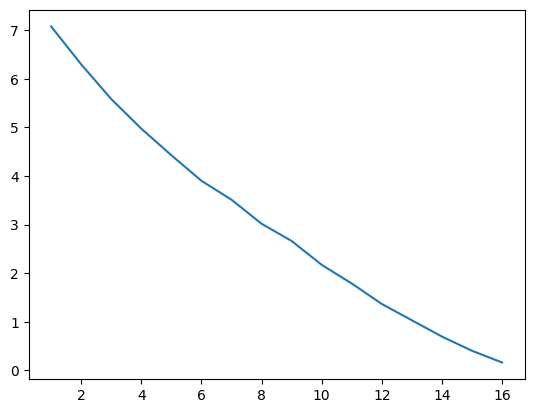

In [198]:
topic_model.elbow_plot()

Because we have a relatively small samples (17 recipes), we couldn't really create a normal elbow plot but based on this plot, we can see that after 8 topics, our line decreases from exponentially to linearly.

Create final moel and evaluate

In [199]:
topic_model.create_topics(num_topics=8)

/Users/kenlam/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [200]:
topic_model.topics_df

,topic,topic_keywords,sentiment
Description,,,
"I recently had the best banh mi of my life at a place called Ca Com in Melbourne. It was a banh mi stuffed with crispy pork belly with a special sauce and plenty of banh mi fixings, and it was absolutely incredible. The standout was the pork itself which was ridiculously juicy with superior crispy crackling! In fact, in recent years I’ve noticed more people ordering pork belly banh mi over the classic “mystery pork slices” version, an observation consistent with an Instagram poll I ran where 57% of respondents voted for crispy pork over the classic mystery pork slices (16%). Does that surprise you? It did me! As wildly popular as the pork belly Banh mi is, it is actually quite hard to find really good ones, with dry meat and not-so-crispy-crackling the most common shortfall. So in case you don’t live around the corner from Ca Com (like me, all the way up in Sydney!), here’s my copycat recipe. It’s not exactly the same (for example, they don’t use pâté, I insist of sticking with this tradition), but I’ve taken inspiration from theirs, including a copycat of their special banh mi sauce. I hope you become as obsessed with this as I have!",0,"beef,Bolognese,Banh,banh,pork",0.986992
"If you’ve been to Vietnam or Vietnamese restaurants, you’ve probably seen these pickles which are commonly served alongside meat dishes, on noodle bowls and stuffed with abundance inside Banh Mi. They are a regular side in traditional Vietnamese dishes and I keep squeezing this recipe in. And it finally dawned on me to file it as a separate recipe! Also, these pickles are generally just great to have in the fridge – for picking at, adding into salads and on the side of non-Vietnamese dishes (it’s not against the law!) – and last at least 2 months. What they taste like – Vinegary but less sharp than typical western pickles (thanks to the rice vinegar), erring more towards sweet and not that salty. Carrot and daikon (white radish) is ideal because they retain a nice crunch for great texture!",3,"salad,daikon,salads,Vietnamese,Banh",0.983938
"These lettuce wraps are not strictly Vietnamese authentic (as far as I know), but they certainly embrace all that we love about Vietnamese food – fresh and light yet never boring, using an abundance of crunchy vegetables, herbs and a killer peanut dipping sauce. That’s definitely a signature of Vietnamese food – wickedly good sauces that make everything delicious! Honestly, you could just smother a bowl of otherwise bland boiled vegetables in that sauce and it will make it 100% scoff-able!",3,"salad,daikon,salads,Vietnamese,Banh",0.999498
"When you see today’s recipe, you’re going to doubt me. How can a recipe with so few ingredients that’s so fast to make be as good as I promise?? Answer: Because the Vietnamese have been making this for centuries! The caramelisation cooking method used in today’s recipe is a traditional Vietnamese technique. Proteins such as chicken, pork, egg and sometimes vegetables are braised in a simple mixture of sugar and water (or coconut juice), seasoned with fish sauce and flavoured with aromatics such as ginger, garlic and chilli. At first the mixture looks thoroughly unimpressive – watery and foamy. Like this: But just give it a mere 12 minutes, and this is what it looks like: I know, right?? Incredible. We should know better than to doubt the Vietnamese! And here’s a nice close up for you, including the inside – proof of juiciness:",1,"marinade,Vietnamese,recipes,braised,recipe",0.993940
"I find it funny that pho is the dish that’s become the superstar of Vietnamese food when bun thit nuong is tastier to me! I adore the contrast of fresh vegetables and herbs with delicious grilled meats, that it’s light and healthy yet anything but dull. It’s a big bowl of delicious, and I shared the chicken version many years ago (bun ga nuong). And as soon as I cracked the pork version, I shared in immediately (just last Wednesday!). And I’m back today w

Now that we have our topics generated, let's merge it with our df

In [201]:
recipes_df3 = recipes_df2.copy()
recipes_df3 = pd.merge(recipes_df3, topic_model.topics_df, on= 'Description', how='left')

In [202]:
recipes_df3.head()

,Title,Ingredients,Instructions,Tags,Description,topic,topic_keywords,sentiment
0,Crispy pork belly banh mi,"1kg / 2 lb pork belly with skin on , NOT SCORE...",Dry skin overnight: Place pork belly on a plat...,NaN,I recently had the best banh mi of my life at ...,0,"beef,Bolognese,Banh,banh,pork",0.986992
1,Vietnamese pickled carrots and daikon (radish),"2 medium carrots , peeled cut into 3mm / 1/10""...","Pickle – In a large bowl, dissolve the salt an...",NaN,If you’ve been to Vietnam or Vietnamese restau...,3,"salad,daikon,salads,Vietnamese,Banh",0.983938
2,Vietnamese Lettuce Wraps with Peanut Sauce,300g / 10 oz peeled whole cooked prawns/shrimp...,"Pickle first – Put the boiling water, salt and...",NaN,These lettuce wraps are not strictly Vietnames...,3,"salad,daikon,salads,Vietnamese,Banh",0.999498
3,Vietnamese Caramel Ginger Chicken,"1 kg / 2 lb skinless chicken thigh fillets , c...","Toss chicken with fish sauce and chilli, then ...",NaN,"When you see today’s recipe, you’re going to d...",1,"marinade,Vietnamese,recipes,braised,recipe",0.993940
4,Vietnamese lemongrass pork noodle bowls (bun t...,1 batch lemongrass marinated pork (it’s marina...,"Pickle – In a large bowl, dissolve the salt an...",NaN,I find it funny that pho is the dish that’s be...,4,"Saigon,Vietnam,Banh,Vietnamese,pho",0.927161


In [203]:
# Drop tag column
recipes_df4 = recipes_df3.copy()
recipes_df4 = recipes_df4.drop(['Tags'], axis=1)

In [204]:
# Rename the topic_keywords into Tags
recipes_df4.rename(columns={'topic_keywords': 'Tags'}, inplace=True)

In [205]:
recipes_df4

,Title,Ingredients,Instructions,Description,topic,Tags,sentiment
0,Crispy pork belly banh mi,"1kg / 2 lb pork belly with skin on , NOT SCORE...",Dry skin overnight: Place pork belly on a plat...,I recently had the best banh mi of my life at ...,0,"beef,Bolognese,Banh,banh,pork",0.986992
1,Vietnamese pickled carrots and daikon (radish),"2 medium carrots , peeled cut into 3mm / 1/10""...","Pickle – In a large bowl, dissolve the salt an...",If you’ve been to Vietnam or Vietnamese restau...,3,"salad,daikon,salads,Vietnamese,Banh",0.983938
2,Vietnamese Lettuce Wraps with Peanut Sauce,300g / 10 oz peeled whole cooked prawns/shrimp...,"Pickle first – Put the boiling water, salt and...",These lettuce wraps are not strictly Vietnames...,3,"salad,daikon,salads,Vietnamese,Banh",0.999498
3,Vietnamese Caramel Ginger Chicken,"1 kg / 2 lb skinless chicken thigh fillets , c...","Toss chicken with fish sauce and chilli, then ...","When you see today’s recipe, you’re going to d...",1,"marinade,Vietnamese,recipes,braised,recipe",0.993940
4,Vietnamese lemongrass pork noodle bowls (bun t...,1 batch lemongrass marinated pork (it’s marina...,"Pickle – In a large bowl, dissolve the salt an...",I find it funny that pho is the dish that’s be...,4,"Saigon,Vietnam,Banh,Vietnamese,pho",0.927161
5,Vietnamese lemongrass pork steaks,"500g/1 lb pork shoulder , skinless and boneles...","Cut pork – Cut into 8 equal, thinnish slices o...",I’ve been wanting to recreate the chargrilled ...,4,"Saigon,Vietnam,Banh,Vietnamese,pho",-0.996114
6,Chicken Banh Mi (Vietnamese sandwich),"2 medium carrots , peeled cut into 2-3mm / 1/1...","Pickle – In a large bowl, dissolve the salt an...",Banh Mi is a meat filled French baguette sandw...,4,"Saigon,Vietnam,Banh,Vietnamese,pho",-0.958432
7,Red Vietnamese Fried Rice,"30g / 2 tbsp unsalted butter 3 garlic cloves ,...",Melt most of the butter in a large non-stick s...,Fried rice always makes for a great quick meal...,5,"meal,dish,Vietnamese,Rice,rice",-0.963759
8,Vietnamese Chicken Salad,"350g/12oz cooked chicken , cut into thin baton...",Dressing: Shake Dressing ingredients in a jar....,While this exact salad is not strictly authent...,3,"salad,daikon,salads,Vietnamese,Banh",0.998437
9,Vietnamese Chicken Pho soup (Pho Ga),"1 tbsp oil , vegetable or canola (or other pla...",Char onion & ginger - Heat oil in a 6 litre / ...,Chicken Pho – called Pho Ga in Vietnamese – is...,2,"noodle,Soups,soup,broth,Pho",0.999039


Yay, we have finally completed our dataframe containing all of the recipes and their generated tags!